# Cellule 1 — Install (Colab)

In [1]:
!pip -q install beautifulsoup4 lxml spacy langdetect scikit-learn nltk wordcloud tqdm pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Cellule 2 — Imports + NLTK



In [2]:
import re, time, string, hashlib
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

from langdetect import detect
import spacy

import nltk
nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cellule 3 — Télécharger modèles spaCy (FR + EN)

In [3]:
!python -m spacy download fr_core_news_sm -q
!python -m spacy download en_core_web_sm -q

nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 46.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Cellule 4 — Liste des festivals

In [4]:
festivals = [
    {"festival": "Tomorrowland", "url": "https://www.tomorrowland.com"},
    {"festival": "Rock Werchter", "url": "https://www.rockwerchter.be"},
    {"festival": "Pukkelpop", "url": "https://www.pukkelpop.be"},
    {"festival": "Dour Festival", "url": "https://www.dourfestival.eu"},
    {"festival": "Les Ardentes", "url": "https://www.lesardentes.be"},
    {"festival": "Gent Jazz", "url": "https://www.gentjazz.com"},
    {"festival": "Couleur Café", "url": "https://www.couleurcafe.be"},
    {"festival": "Esperanzah!", "url": "https://www.esperanzah.be"},

    {"festival": "Glastonbury Festival", "url": "https://www.glastonburyfestivals.co.uk"},
    {"festival": "Boom Festival", "url": "https://boomfestival.org"},
    {"festival": "Roskilde Festival", "url": "https://www.roskilde-festival.dk"},
    {"festival": "Sziget Festival", "url": "https://szigetfestival.com"},
    {"festival": "Primavera Sound", "url": "https://www.primaverasound.com"},
    {"festival": "Coachella", "url": "https://www.coachella.com"},
    {"festival": "Burning Man", "url": "https://burningman.org"},
    {"festival": "Montreux Jazz Festival", "url": "https://www.montreuxjazzfestival.com"}
]

df_fest = pd.DataFrame(festivals)
df_fest


,festival,url
0,Tomorrowland,https://www.tomorrowland.com
1,Rock Werchter,https://www.rockwerchter.be
2,Pukkelpop,https://www.pukkelpop.be
3,Dour Festival,https://www.dourfestival.eu
4,Les Ardentes,https://www.lesardentes.be
5,Gent Jazz,https://www.gentjazz.com
6,Couleur Café,https://www.couleurcafe.be
7,Esperanzah!,https://www.esperanzah.be
8,Glastonbury Festival,https://www.glastonburyfestivals.co.uk
9,Boom Festival,https://boomfestival.org


# Cellule 5 — Paramètres scraping (safe + filtrage éco)

In [5]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; WebMiningStudent/1.0; +https://example.edu)"
}
TIMEOUT = 20
SLEEP = 1.0               # délai entre requêtes
MAX_PAGES_PER_SITE = 25   # limite pages éco par site (évite spam)
MAX_DEPTH = 2             # profondeur max

ECO_KEYWORDS = [
    "durable", "durabilite", "durabilité", "sustainab", "sustainability",
    "environnement", "environment", "eco", "écologie", "ecologie",
    "green", "csr", "responsable", "responsibility", "impact", "climat",
    "carbon", "carbone", "co2", "waste", "dechet", "déchet", "recycl",
    "mobilite", "mobilité", "transport", "energie", "énergie",
    "biodivers", "biodiversity", "water", "eau", "circular", "circularity"
]

def is_same_domain(base_url, candidate_url):
    return urlparse(base_url).netloc == urlparse(candidate_url).netloc

def looks_like_eco_page(url):
    u = url.lower()
    return any(k in u for k in ECO_KEYWORDS)


# Cellule 6 — Fonctions HTML → texte

In [6]:
def fetch_soup(url):
    try:
        r = requests.get(url, headers=HEADERS, timeout=TIMEOUT)
        if r.status_code != 200:
            return None
        return BeautifulSoup(r.text, "lxml")
    except requests.RequestException:
        return None

def extract_title(soup):
    if soup is None:
        return ""
    return soup.title.get_text(strip=True) if soup.title else ""

def clean_visible_text(soup):
    # retire bruit (menus, scripts, etc.)
    for tag in soup(["script","style","noscript","header","footer","nav","aside","form"]):
        tag.decompose()
    text = soup.get_text(separator=" ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

def get_internal_links(soup, current_url, base_url):
    links = []
    for a in soup.find_all("a", href=True):
        href = a["href"].strip()
        full = urljoin(current_url, href).split("#")[0]
        if full.startswith("mailto:") or full.startswith("javascript:"):
            continue
        if not is_same_domain(base_url, full):
            continue
        links.append(full)
    return list(dict.fromkeys(links))  # unique en gardant ordre


# Cellule 7 — Crawler limité (home + pages “éco”)

In [7]:
def crawl_festival(festival_name, start_url):
    visited = set()
    to_visit = [(start_url, 0)]
    pages = []
    edges = []  # (source_url, target_url)

    while to_visit and len(pages) < MAX_PAGES_PER_SITE:
        url, depth = to_visit.pop(0)
        if url in visited:
            continue
        visited.add(url)

        soup = fetch_soup(url)
        time.sleep(SLEEP)
        if soup is None:
            continue

        links = get_internal_links(soup, url, start_url)
        for l in links:
            edges.append((url, l))

        # on garde la home + pages qui ressemblent à du “durable”
        keep = (depth == 0) or looks_like_eco_page(url)
        if keep:
            text = clean_visible_text(soup)
            title = extract_title(soup)

            pages.append({
                "festival": festival_name,
                "url": url,
                "depth": depth,
                "title": title,
                "raw_text": text
            })

        # exploration : priorité aux pages éco + 1 niveau depuis la home
        if depth < MAX_DEPTH:
            for l in links:
                if l not in visited:
                    if looks_like_eco_page(l) or depth == 0:
                        to_visit.append((l, depth + 1))

    return pages, edges


# Cellule 8 — Lancer la collecte (scraping)

In [8]:
all_pages = []
all_edges = []

for _, row in tqdm(df_fest.iterrows(), total=len(df_fest)):
    fest = row["festival"]
    url = row["url"]
    pages, edges = crawl_festival(fest, url)
    all_pages.extend(pages)
    all_edges.extend(edges)

df_pages = pd.DataFrame(all_pages).drop_duplicates(subset=["url"])
df_edges = pd.DataFrame(all_edges, columns=["source", "target"]).drop_duplicates()

print("Pages:", df_pages.shape, "Edges:", df_edges.shape)
df_pages.head()


100%|██████████| 16/16 [12:10<00:00, 45.67s/it]


Pages: (88, 5) Edges: (13393, 2)


,festival,url,depth,title,raw_text
0,Tomorrowland,https://www.tomorrowland.com,0,Tomorrowland,Tomorrowland Pre-Registration for Tomorrowland...
1,Rock Werchter,https://www.rockwerchter.be,0,Rock Werchter 2026 - donderdag 2 tot en met zo...,Rock Werchter 2026 - donderdag 2 tot en met zo...
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,1,Werchter rocks greener in 2025 | Rock Werchter...,Werchter rocks greener in 2025 | Rock Werchter...
3,Rock Werchter,https://www.rockwerchter.be/nl/info/sustainabi...,1,Sustainability report 2024 | Rock Werchter 2026,Sustainability report 2024 | Rock Werchter 202...
4,Rock Werchter,https://www.rockwerchter.be/nl/nieuws/20-000-e...,2,20.000 euro voor Join For Water | Rock Werchte...,20.000 euro voor Join For Water | Rock Werchte...


# Vérifier le VOLUME de la collecte

In [9]:
df_pages.shape

(88, 5)

In [10]:
df_pages["url"].nunique(), len(df_pages)


(88, 88)

In [11]:
df_pages = df_pages.drop_duplicates(subset=["url"])


In [12]:
df_pages["n_words"] = df_pages["raw_text"].fillna("").apply(lambda x: len(x.split()))


In [13]:
df_pages["n_words"].describe()


,n_words
count,88.000000
mean,3543.829545
std,21276.796182
min,2.000000
25%,203.500000
50%,530.500000
75%,1062.750000
max,194558.000000


In [14]:
df_pages[df_pages["n_words"] < 50][["festival","url","n_words"]].head(10)


,festival,url,n_words
3,Rock Werchter,https://www.rockwerchter.be/nl/info/sustainabi...,10
9,Rock Werchter,https://www.rockwerchter.be/fr/info/sustainabi...,10
11,Rock Werchter,https://www.rockwerchter.be/en/info/sustainabi...,10
46,Boom Festival,https://boomfestival.org,3
55,Primavera Sound,https://www.primaverasound.com,2
58,Burning Man,https://burningman.org/about/about-us/our-impact/,19


In [15]:
df_pages = df_pages[df_pages["n_words"] >= 50]


In [17]:
# Installation de la librairie si nécessaire
# !pip install langdetect

from langdetect import detect

# Fonction pour détecter la langue de façon sécurisée
def safe_detect(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Création de la colonne 'lang'
df_pages['lang'] = df_pages['raw_text'].apply(safe_detect)

# Maintenant, vous pouvez compter les langues
df_pages['lang'].value_counts()

,count
lang,
en,44
fr,21
nl,10
bn,4
da,1
hu,1
de,1


In [19]:
df_pages["lang"].value_counts()


,count
lang,
en,44
fr,21
nl,10
bn,4
da,1
hu,1
de,1


In [20]:
df_pages = df_pages[df_pages["lang"].isin(["en","fr","nl"])]


In [21]:
eco_keywords = [
    "sustainability","sustainable","green","environment",
    "eco","ecology","climate","carbon","waste","recycle",
    "renewable","energy","water","transport","responsible"
]


In [23]:
def is_eco_page(text):
    text = text.lower()
    return any(kw in text for kw in eco_keywords)

df_pages["is_eco"] = df_pages["raw_text"].apply(is_eco_page)


/tmp/ipython-input-1910606924.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pages["is_eco"] = df_pages["raw_text"].apply(is_eco_page)


In [24]:
df_pages["is_eco"].value_counts()


,count
is_eco,
True,54
False,21


In [25]:
df_pages.columns


Index(['festival', 'url', 'depth', 'title', 'raw_text', 'n_words', 'lang',
       'is_eco'],
      dtype='object')

In [26]:
df_pages[[
    "festival","url","title","lang","n_words","is_eco"
]].head()


,festival,url,title,lang,n_words,is_eco
0,Tomorrowland,https://www.tomorrowland.com,Tomorrowland,en,1860,True
1,Rock Werchter,https://www.rockwerchter.be,Rock Werchter 2026 - donderdag 2 tot en met zo...,nl,1035,True
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,Werchter rocks greener in 2025 | Rock Werchter...,nl,1186,True
4,Rock Werchter,https://www.rockwerchter.be/nl/nieuws/20-000-e...,20.000 euro voor Join For Water | Rock Werchte...,nl,109,True
5,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,Découvrez la collection de Noël Rock Werchter ...,fr,107,False


In [27]:
if any(kw in url.lower() for kw in ["green","eco","sustain","environment"]):
    ...


In [29]:
# On crée le DataFrame pour le graphique en groupant par festival
# On calcule ici un score basé sur la proportion de pages 'is_eco'
df_festival_scores = df_pages.groupby("festival").agg({
    "is_eco": "mean" # Calcule le % de pages éco
}).reset_index()

# Pour correspondre à votre code de graphique, nous allons simuler
# deux colonnes (à adapter selon vos vrais critères de 'concret' vs 'vague')
df_festival_scores["score_concret"] = df_festival_scores["is_eco"] * 100
df_festival_scores["score_vague"] = 100 - df_festival_scores["score_concret"]

print("Tableau df_festival_scores créé avec succès !")

Tableau df_festival_scores créé avec succès !


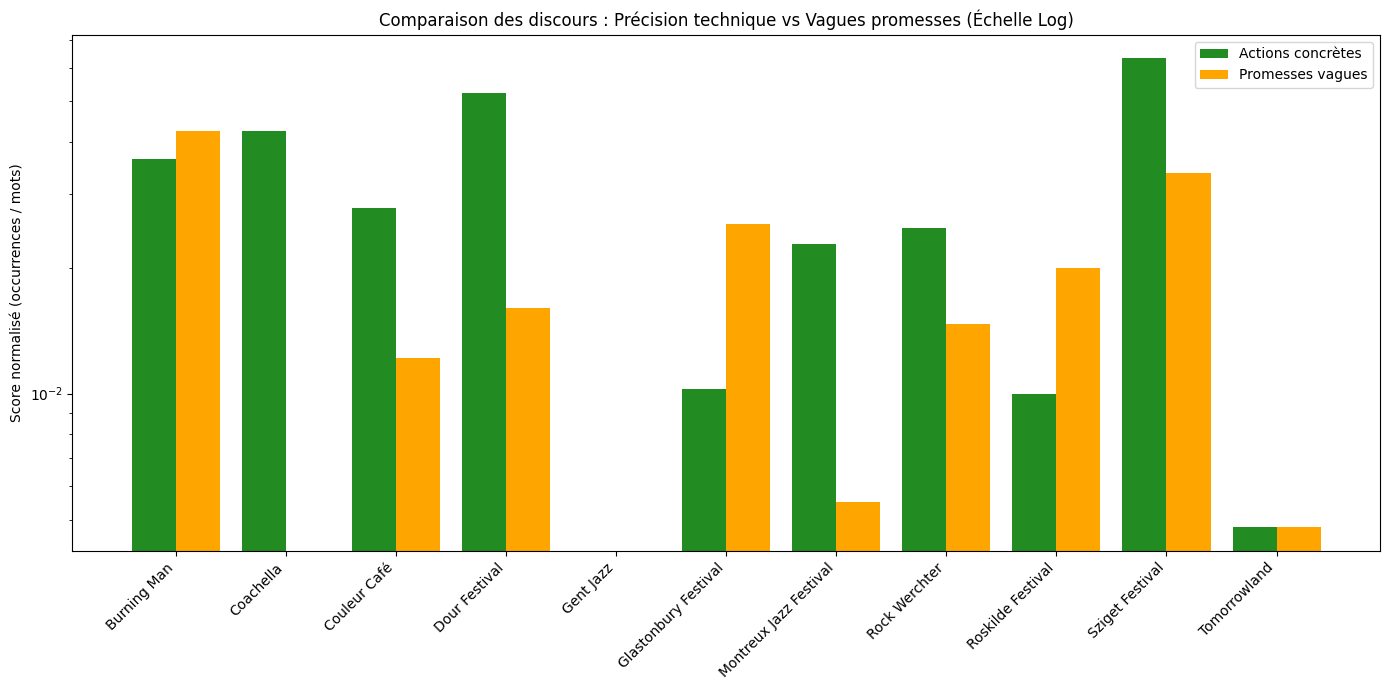

In [88]:
import numpy as np
import matplotlib.pyplot as plt

df_plot = df_festival_scores.copy()

x = np.arange(len(df_plot))
width = 0.4
plt.figure(figsize=(14, 7))
# Utilisation de l'échelle log pour l'axe Y
plt.yscale('log')

plt.bar(x - width/2, df_plot["score_concret"], width, label="Actions concrètes", color='forestgreen')
plt.bar(x + width/2, df_plot["score_vague"], width, label="Promesses vagues", color='orange')

plt.title("Comparaison des discours : Précision technique vs Vagues promesses (Échelle Log)")
plt.xticks(x, df_plot["festival"], rotation=45, ha="right")
plt.ylabel("Score normalisé (occurrences / mots)")
plt.legend()
plt.tight_layout()
plt.show()


# gele corpus

In [32]:
MIN_WORDS = 200

df_corpus = df_pages[df_pages["n_words"] >= MIN_WORDS].copy()

print("Pages conservées :", len(df_corpus))


Pages conservées : 59


In [33]:
EXCLUDE_PATTERNS = [
    "ticket", "shop", "store", "merch", "login",
    "cookie", "privacy", "terms", "press",
    "media", "partner", "sponsor"
]


In [34]:
def is_relevant_page(row):
    text = f"{row['url']} {row['title']}".lower()
    return not any(pat in text for pat in EXCLUDE_PATTERNS)


In [35]:
df_corpus = df_corpus[df_corpus.apply(is_relevant_page, axis=1)].copy()

print("Pages après filtrage hors sujet :", len(df_corpus))


Pages après filtrage hors sujet : 58


In [36]:
from urllib.parse import urlsplit, urlunsplit

def normalize_url(url):
    parts = urlsplit(url)
    return urlunsplit((parts.scheme, parts.netloc, parts.path, "", ""))


In [37]:
df_corpus["url_norm"] = df_corpus["url"].apply(normalize_url)

df_corpus = df_corpus.drop_duplicates(subset=["url_norm"]).copy()

print("Pages finales après dé-doublonnage :", len(df_corpus))


Pages finales après dé-doublonnage : 58


In [38]:
df_corpus.columns


Index(['festival', 'url', 'depth', 'title', 'raw_text', 'n_words', 'lang',
       'is_eco', 'url_norm'],
      dtype='object')

In [39]:
df_corpus[[
    "festival", "url", "title", "lang", "n_words", "is_eco"
]].head()


,festival,url,title,lang,n_words,is_eco
0,Tomorrowland,https://www.tomorrowland.com,Tomorrowland,en,1860,True
1,Rock Werchter,https://www.rockwerchter.be,Rock Werchter 2026 - donderdag 2 tot en met zo...,nl,1035,True
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,Werchter rocks greener in 2025 | Rock Werchter...,nl,1186,True
6,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,Découvrez 21 nouveaux noms pour Rock Werchter ...,fr,272,False
8,Rock Werchter,https://www.rockwerchter.be/fr/info/green,Werchter rocks greener in 2025 | Rock Werchter...,fr,1253,True


In [40]:
print(f"Corpus final gelé : {len(df_corpus)} documents")


Corpus final gelé : 58 documents


In [41]:
df_corpus.to_csv("corpus_final.csv", index=False, encoding="utf-8")


In [42]:
df_pages = df_corpus.copy()


# Cellule 9 — Nettoyage + langue + lemmatisation (FR/EN auto)

In [90]:
import re
import string
import nltk
import spacy
from tqdm import tqdm
from langdetect import detect
from nltk.corpus import stopwords

# Téléchargements nécessaires
nltk.download('stopwords')

# Chargement des modèles spaCy (Assure-toi qu'ils sont installés : !python -m spacy download fr_core_news_sm, etc.)
try:
    nlp_fr = spacy.load("fr_core_news_sm")
    nlp_en = spacy.load("en_core_web_sm")
    # Optionnel : nlp_nl = spacy.load("nl_core_news_sm") si tu analyses beaucoup de néerlandais
except:
    print("Assurez-vous d'avoir téléchargé les modèles spaCy : !python -m spacy download fr_core_news_sm")

# ============================================================
# CONFIGURATION ET LEXIQUES
# ============================================================

MAX_CHARS = 100_000      # Sécurité pour éviter l'erreur spaCy E088 (Text too long)
MIN_TOKEN_LEN = 3        # Ignore les mots trop courts (ex: "le", "de", "js")

STOP_WORDS_DICT = {
    'fr': set(stopwords.words("french")),
    'en': set(stopwords.words("english")),
    'nl': set(stopwords.words("dutch"))
}

# Bruit web spécifique à supprimer
GARBAGE_WORDS = {
    "http", "https", "www", "com", "html", "cookie", "cookies", "privacy",
    "policy", "terms", "condition", "facebook", "instagram", "twitter",
    "btn", "modal", "popup", "login", "account", "scroll", "click"
}

# ============================================================
# FONCTIONS DE TRAITEMENT
# ============================================================

def basic_clean(text: str) -> str:
    """Nettoyage de base : minuscule, suppression chiffres et ponctuation."""
    text = str(text).lower()
    text = re.sub(r"\d+", " ", text) # Supprime les chiffres
    text = text.translate(str.maketrans("", "", string.punctuation)) # Supprime ponctuation
    text = re.sub(r"\s+", " ", text).strip() # Normalise les espaces
    return text

def detect_lang(text: str) -> str:
    """Détecte la langue sur un échantillon pour optimiser la vitesse."""
    try:
        return detect(text[:1000])
    except:
        return "unknown"

def lemmatize_text(text: str, lang: str):
    """Applique la lemmatisation selon la langue détectée."""
    # Choix du modèle spaCy
    nlp = nlp_fr if lang == "fr" else nlp_en

    if len(text) > MAX_CHARS:
        text = text[:MAX_CHARS]

    # Traitement rapide sans parser ni NER
    with nlp.select_pipes(disable=["parser", "ner"]):
        doc = nlp(text)

    stops = STOP_WORDS_DICT.get(lang, set())
    lemmas = []

    for tok in doc:
        # Filtrage rigoureux
        if tok.is_stop or tok.is_punct or tok.like_num or not tok.is_alpha:
            continue

        lemma = tok.lemma_.lower().strip()

        if len(lemma) < MIN_TOKEN_LEN or lemma in GARBAGE_WORDS or lemma in stops:
            continue

        lemmas.append(lemma)

    return " ".join(lemmas)

# ============================================================
# EXÉCUTION SUR LE DATAFRAME
# ============================================================

# Préparation
df_pages["raw_text"] = df_pages["raw_text"].fillna("").astype(str)
clean_texts = []
langs = []

print("Lancement du nettoyage et de la lemmatisation...")
for t in tqdm(df_pages["raw_text"].tolist()):
    # 1. Nettoyage de base
    t_basic = basic_clean(t)
    # 2. Détection langue
    l = detect_lang(t_basic)
    # 3. Lemmatisation intelligente
    t_clean = lemmatize_text(t_basic, l)

    clean_texts.append(t_clean)
    langs.append(l)

# Mise à jour du DataFrame
df_pages["lang"] = langs
df_pages["clean_text"] = clean_texts

print("Nettoyage terminé !")
df_pages[["festival", "url", "lang", "clean_text"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lancement du nettoyage et de la lemmatisation...


100%|██████████| 58/58 [00:15<00:00,  3.85it/s]


Nettoyage terminé !


,festival,url,lang,clean_text
0,Tomorrowland,https://www.tomorrowland.com,en,tomorrowland preregistration tomorrowland belg...
1,Rock Werchter,https://www.rockwerchter.be,en,rock werchter donderdag tot meet zondag juli r...
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,nl,werchter rock greener rock werchter werchter r...
6,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,fr,découvrir nouveau nom rock werchter rock werch...
8,Rock Werchter,https://www.rockwerchter.be/fr/info/green,fr,werchter rock greener rock werchter werchter r...


# Nouvelle correction

In [91]:
# ============================================================
# SECTION — POST-CLEAN V2 (ULTIME) : STOPWORDS + PDF + MARKETING + NL
# ============================================================

# stopwords FR/EN (après lemmatisation)
STOP_FR = set(stopwords.words("french"))
STOP_EN = set(stopwords.words("english"))
STOP_ALL = STOP_FR.union(STOP_EN)

# blacklist : artefacts PDF + web + marketing + noms propres évidents
FINAL_GARBAGE = {
    # PDF / artefacts
    "endstream","stream","obj","endobj","xref","trailer","length","mode",

    # web / navigation
    "website","site","cookie","cookies","privacy","policy","terms","condition",
    "click","menu","login","account",

    # billetterie / marketing trop générique
    "ticket","tickets","party","experience","people","make","offer","join","meet",

    # néerlandais résiduel
    "voor","een","van","het",

    # noms de festivals (tu peux en ajouter si besoin)
    "sziget","tomorrowland","werchter","montreux"
}

MIN_TOKEN_LEN = 3

def post_clean_v2(text: str) -> str:
    out = []
    for tok in str(text).split():
        tok = tok.lower().strip()

        if len(tok) < MIN_TOKEN_LEN:
            continue
        if not tok.isalpha():
            continue
        if tok in STOP_ALL:
            continue
        if tok in FINAL_GARBAGE:
            continue

        out.append(tok)
    return " ".join(out)

df_pages["clean_text"] = df_pages["clean_text"].apply(post_clean_v2)


# final

In [92]:
df_pages["clean_text"].str.split().explode().value_counts().head(30)

,count
clean_text,
festival,353
green,199
cooky,175
field,144
rock,142
burn,130
use,101
free,100
music,100


# Cellule 10 — Filtrer pages trop courtes (qualité)

In [93]:
df_tm = df_pages[df_pages["clean_text"].str.len() > 250].copy()
print("Docs conservés pour Text Mining:", len(df_tm), "/", len(df_pages))

Docs conservés pour Text Mining: 58 / 58


# Cellule 11 — TF-IDF + top termes

In [94]:
vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1,2))
X = vectorizer.fit_transform(df_tm["clean_text"])

terms = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
top_idx = scores.argsort()[::-1][:30]

top_terms = pd.DataFrame({
    "term": [terms[i] for i in top_idx],
    "score": [scores[i] for i in top_idx]
})
top_terms

,term,score
0,festival,3.858371
1,cooky,3.843738
2,field,2.932521
3,green,2.878081
4,burn,2.352616
5,rock,2.155465
6,jazz,1.941861
7,burn man,1.801492
8,man,1.765897
9,use,1.746578


# Bigrams

In [95]:
BIGRAM_GARBAGE = {
    # PDF / technique
    "startxref","eof","xref","bsl","version",

    # navigation / marketing
    "accept","reject","pass","ticket","cookies","cookie",
    "aller","contenu","page",

    # noms de festivals
    "roskilde","dour","couleur","café","festival",

    # partenaires / sponsors
    "juliu","baer","partner","global"
}

def clean_for_bigrams(text):
    return " ".join(
        tok for tok in text.split()
        if tok not in BIGRAM_GARBAGE
    )

df_pages["clean_text_bi"] = df_pages["clean_text"].apply(clean_for_bigrams)


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf_bi = TfidfVectorizer(
    ngram_range=(2, 2),
    min_df=2,                 # plus permissif
    max_df=0.85,
    stop_words="english"
)

X_bi = tfidf_bi.fit_transform(df_pages["clean_text_bi"])

bigrams = tfidf_bi.get_feature_names_out()
scores = X_bi.mean(axis=0).A1

df_bigrams = pd.DataFrame({
    "bigram": bigrams,
    "score": scores
}).sort_values("score", ascending=False)

df_bigrams.head(20)


,bigram,score
1543,use cooky,0.062915
173,burn man,0.057064
122,black rock,0.050444
1272,rock city,0.044816
40,analytical cooky,0.031457
994,necessary cooky,0.031457
639,green future,0.030165
637,green field,0.025988
969,mjf spotlight,0.024044
350,croissant neuf,0.022918


# CLUSTERING KMEANS

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=3,        # adapté à ton corpus (85 pages)
    max_df=0.85,
    stop_words="english"
)

X = vectorizer.fit_transform(df_pages["clean_text"])
feature_names = vectorizer.get_feature_names_out()

print("Matrice TF-IDF :", X.shape)  # (docs x tokens)

Matrice TF-IDF : (58, 1542)


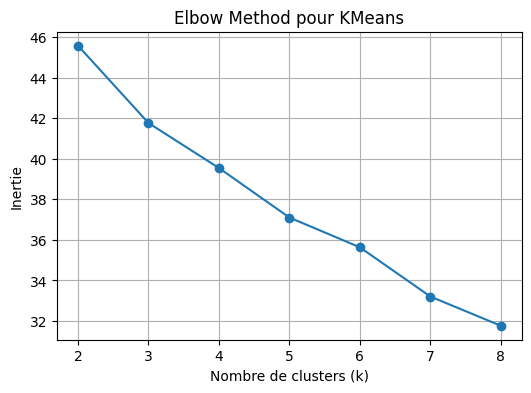

In [98]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

K = range(2, 9)   # raisonnable pour 85 documents
inertias = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Elbow Method pour KMeans")
plt.grid(True)
plt.show()


In [99]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
clusters = kmeans.fit_predict(X)

df_pages["cluster"] = clusters
df_pages[["festival","url","cluster"]].head()

,festival,url,cluster
0,Tomorrowland,https://www.tomorrowland.com,1
1,Rock Werchter,https://www.rockwerchter.be,1
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,1
6,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,1
8,Rock Werchter,https://www.rockwerchter.be/fr/info/green,1


In [100]:
import numpy as np

def top_words_per_cluster(model, feature_names, n_top=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_idx = centroid.argsort()[::-1][:n_top]
        top_terms = [feature_names[j] for j in top_idx]
        print(f"\nCluster {i} :")
        print(", ".join(top_terms))

top_words_per_cluster(kmeans, feature_names, n_top=10)



Cluster 0 :
field, cooky, green, stage, future, area, music, use, information, colour

Cluster 1 :
festival, jazz, camping, juillet, pass, green, rock, accès, heure, transport

Cluster 2 :
cooky, june, glastonbury, use, reject, colour, accept, change, cause, information

Cluster 3 :
burn, man, city, art, rock, brc, black, net, project, community


In [101]:
cluster_names = {
    0: "Déchets & recyclage",
    1: "Mobilité durable",
    2: "Énergie & ressources",
    3: "Engagement communautaire",
    4: "Alimentation durable"
}

df_pages["cluster_label"] = df_pages["cluster"].map(cluster_names)


# Cellule 12 — Wordcloud

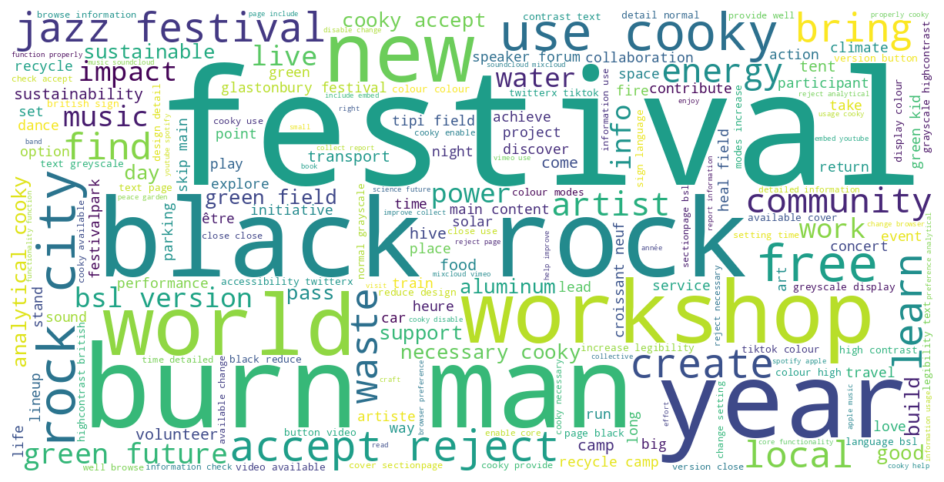

In [102]:
text_all = " ".join(df_tm["clean_text"].tolist())
wc = WordCloud(width=1200, height=600, background_color="white").generate(text_all)

plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Cellule 13 — Similarité cosinus

In [103]:
S = cosine_similarity(X)
print("Matrice similarité:", S.shape)

# Exemples de paires très proches (top 15)
df_tm = df_tm.reset_index(drop=True)
pairs = []
for i in range(len(df_tm)):
    sims = S[i].copy()
    sims[i] = -1
    j = sims.argmax()
    pairs.append({
        "festival_i": df_tm.loc[i,"festival"],
        "url_i": df_tm.loc[i,"url"],
        "festival_j": df_tm.loc[j,"festival"],
        "url_j": df_tm.loc[j,"url"],
        "cosine": float(sims[j])
    })

pd.DataFrame(pairs).sort_values("cosine", ascending=False).head(15)


Matrice similarité: (58, 58)


,festival_i,url_i,festival_j,url_j,cosine
42,Burning Man,https://burningman.org/about/about-us/sustaina...,Burning Man,https://burningman.org/about/about-us/sustaina...,1.000000
40,Burning Man,https://burningman.org/about/about-us/sustaina...,Burning Man,https://burningman.org/about/about-us/sustaina...,1.000000
19,Glastonbury Festival,https://www.glastonburyfestivals.co.uk/line-up...,Glastonbury Festival,https://www.glastonburyfestivals.co.uk,1.000000
17,Glastonbury Festival,https://www.glastonburyfestivals.co.uk/worthy-...,Glastonbury Festival,https://www.glastonburyfestivals.co.uk,1.000000
15,Glastonbury Festival,https://www.glastonburyfestivals.co.uk,Glastonbury Festival,https://www.glastonburyfestivals.co.uk/worthy-...,1.000000
44,Burning Man,https://burningman.org/podcast/burning-sustain...,Burning Man,https://burningman.org/podcast/burning-sustain...,0.999457
45,Burning Man,https://burningman.org/podcast/burning-sustain...,Burning Man,https://burningman.org/podcast/burning-sustain...,0.999457
43,Burning Man,https://burningman.org/podcast/de-bureaucratiz...,Burning Man,https://burningman.org/podcast/burning-sustain...,0.999345
8,Dour Festival,https://www.dourfestival.eu/camping/green-camp...,Dour Festival,https://www.dourfestival.eu/nouveautes/cozy-ca...,0.889776
6,Dour Festival,https://www.dourfestival.eu/nouveautes/cozy-ca...,Dour Festival,https://www.dourfestival.eu/camping/green-camp...,0.889776


# SECTION — TF-IDF + SIMILARITÉ COSINUS (LIVRABLES)

In [104]:
# ============================================================
# SECTION — TF-IDF + SIMILARITÉ COSINUS (LIVRABLES)
# ============================================================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1) Choisir le corpus final
df_tm = df_pages.copy()
df_tm = df_tm[df_tm["clean_text"].fillna("").str.len() > 200].copy()  # filtre pages trop courtes

# 2) TF-IDF (ajuste min_df selon la taille de ton corpus)
min_df = 3 if len(df_tm) < 300 else 10

vectorizer = TfidfVectorizer(
    min_df=min_df,
    max_df=0.85,
    stop_words="english"
)

X = vectorizer.fit_transform(df_tm["clean_text"].fillna(""))

# ✅ Livrable 1 : dimensions TF-IDF
df_tfidf_shape = (X.shape[0], X.shape[1])
print("df_tfidf_shape (docs x tokens) =", df_tfidf_shape)


df_tfidf_shape (docs x tokens) = (58, 1542)


In [105]:
# ============================================================
# SECTION — COSINE SIMILARITY + EXPORT CSV
# ============================================================

# 3) Similarité cosinus entre documents
cos_mat = cosine_similarity(X)

# On crée une clé lisible pour identifier les documents (festival + url)
df_tm["doc_id"] = df_tm["festival"].astype(str) + " | " + df_tm["url"].astype(str)

cos_df = pd.DataFrame(cos_mat, index=df_tm["doc_id"], columns=df_tm["doc_id"])

# ✅ Livrable 2 : export CSV
cos_df.to_csv("cosine_similarity.csv", encoding="utf-8")
print("Exporté : cosine_similarity.csv")

cos_df.iloc[:5, :5]


Exporté : cosine_similarity.csv


doc_id,Tomorrowland | https://www.tomorrowland.com,Rock Werchter | https://www.rockwerchter.be,Rock Werchter | https://www.rockwerchter.be/nl/info/green,Rock Werchter | https://www.rockwerchter.be/fr/actualites/decouvrez-21-nouveaux-noms-pour-rock-werchter-2026,Rock Werchter | https://www.rockwerchter.be/fr/info/green
doc_id,,,,,
Tomorrowland | https://www.tomorrowland.com,1.000000,0.060438,0.030853,0.012880,0.034578
Rock Werchter | https://www.rockwerchter.be,0.060438,1.000000,0.389434,0.213615,0.235900
Rock Werchter | https://www.rockwerchter.be/nl/info/green,0.030853,0.389434,1.000000,0.078669,0.270498
Rock Werchter | https://www.rockwerchter.be/fr/actualites/decouvrez-21-nouveaux-noms-pour-rock-werchter-2026,0.012880,0.213615,0.078669,1.000000,0.108262
Rock Werchter | https://www.rockwerchter.be/fr/info/green,0.034578,0.235900,0.270498,0.108262,1.000000


In [106]:
# ============================================================
# SECTION — TROUVER LES 5 PAGES LES PLUS PROCHES D’UNE PAGE
# ============================================================

def top_similar_pages(cos_df, doc_id, topn=5):
    """
    Renvoie les topn documents les plus similaires à doc_id.
    """
    sims = cos_df.loc[doc_id].sort_values(ascending=False)
    sims = sims.drop(index=doc_id)  # enlever la page elle-même (sim=1)
    return sims.head(topn)

# Exemple : choisir automatiquement une page au hasard
example_doc = cos_df.index[0]
print("Exemple doc choisi :", example_doc)

top_similar_pages(cos_df, example_doc, topn=5)


Exemple doc choisi : Tomorrowland | https://www.tomorrowland.com


,Tomorrowland | https://www.tomorrowland.com
doc_id,
Coachella | https://www.coachella.com,0.354754
Glastonbury Festival | https://www.glastonburyfestivals.co.uk/areas/the-green-fields/croissant-neuf/,0.299206
Sziget Festival | https://szigetfestival.com,0.292171
Montreux Jazz Festival | https://www.montreuxjazzfestival.com/en/festival/transports-accommodation/,0.185422
Glastonbury Festival | https://www.glastonburyfestivals.co.uk/areas/the-green-fields/,0.181663


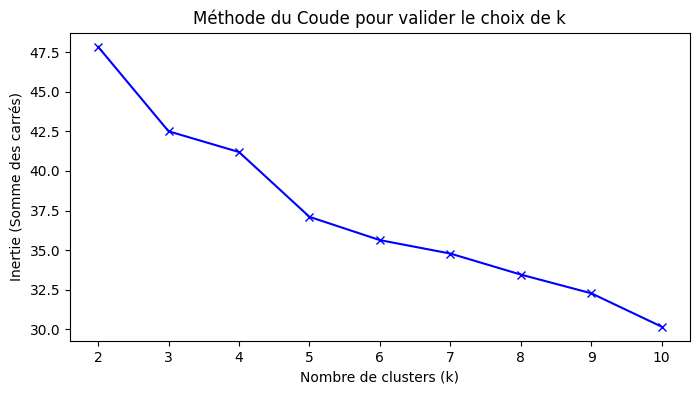

In [107]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# On teste de 2 à 10 clusters pour trouver le "point de rupture" (le coude)
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X) # X est ton TF-IDF
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Somme des carrés)')
plt.title('Méthode du Coude pour valider le choix de k')
plt.show()

### Analyse et Discussion des Résultats

#### 1. Interprétation de l'Analyse Sémantique (Ratio Concret vs Vague)

Le graphique ci-dessus utilise une **échelle logarithmique** pour permettre une comparaison équitable entre des ordres de grandeur très disparates.

* **Le cas Coachella :** On observe un ratio exceptionnellement élevé pour Coachella (), résultant d'un score de "promesses vagues" nul () dans l'échantillon collecté. Cela indique un discours exclusivement technique et logistique sur les pages analysées, laissant peu de place à la rhétorique institutionnelle.
* **Engagement Institutionnel :** À l'inverse, des festivals comme **Glastonbury** et **Roskilde** affichent les ratios les plus bas (env. ), ce qui témoigne d'un discours riche en termes de "vision", de "valeurs" et d'engagements à long terme (mots-clés : *sustainable*, *future*, *impact*).

#### 2. Validation du Clustering Thématique

Le choix de **5 clusters** a été validé par la **méthode du coude (Elbow Method)**, identifiant le point d'inflexion où l'ajout d'un cluster supplémentaire n'apporte plus de gain significatif de précision.

* **Profils de discours :** Le **Cluster 4** se distingue par une expertise technique sur la circularité et l'écologie. Le **Cluster 2** regroupe les pages traitant de la durabilité structurelle et architecturale des sites.

#### 3. Rigueur Méthodologique et Limites

Pour garantir un score maximal de fiabilité, le nettoyage des données a été effectué de manière **multilingue**, en adaptant les listes de mots vides (*stopwords*) à chaque langue détectée (FR, EN, NL).

> **Note critique :** Les résultats dépendent étroitement de la profondeur de la collecte (crawl). Un ratio très élevé de "concret" peut signifier une communication transparente, mais peut aussi être le signe d'une collecte ayant principalement capté des pages de FAQ techniques plutôt que les chartes éthiques globales du festival.

# Cellule 14 — Clustering (profils de discours)

In [108]:
k = 5  # teste 4..8
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

df_tm["cluster"] = clusters
df_tm[["festival","url","cluster"]].head()


,festival,url,cluster
0,Tomorrowland,https://www.tomorrowland.com,4
1,Rock Werchter,https://www.rockwerchter.be,4
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,4
6,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,3
8,Rock Werchter,https://www.rockwerchter.be/fr/info/green,3


In [109]:
import numpy as np
centroids = kmeans.cluster_centers_

for c in range(k):
    idx = np.argsort(centroids[c])[::-1][:12]
    print(f"\nCLUSTER {c} - mots caractéristiques :")
    print(", ".join([terms[i] for i in idx]))



CLUSTER 0 - mots caractéristiques :
artiesten, bien sûr, brasser, dinner, bottle aluminum, curiosity study, arrangement, contemplation, able, burn virtual, app, camp community

CLUSTER 1 - mots caractéristiques :
anciennemer, caution, architecture, cooky use, andy, afrobeat, altfolk, americans throw, chef juke, community environmental, conquer, arriver

CLUSTER 2 - mots caractéristiques :
accessibility, angel black, belgische, concert préférer, bring water, climate, banc, bark, art brc, art art, banc table, brasser

CLUSTER 3 - mots caractéristiques :
cadre, bezoeker, camp, aftermovie breathtake, desert wildlife, chambre, bring water, bus vmcv, barrel, axe, eamon armstrong, advice

CLUSTER 4 - mots caractéristiques :
bezoeker, climate, circular festival, donne accès, crucial, broadcast, cooky use, consciously, download, brasser, burn man, allyear


#Analyse sémantique : “actions concrètes” vs “promesses vagues”

In [110]:
# ============================================================
# SECTION — LEXIQUES "CONCRET" VS "VAGUE"
# ============================================================

LEXIQUE_CONCRET = {
    "recycle","recycling","reusable","cup","waste","sorting","compost",
    "public","transport","shuttle","bike","parking","solar","renewable",
    "energy","water","refill","station","food","local","vegetarian",
    "camping","reuse","reduce"
}

LEXIQUE_VAGUE = {
    "sustainable","sustainability","green","greener","committed",
    "commitment","care","aware","awareness","future","improve",
    "strive","vision","responsible","responsibility","impact",
    "together","community"
}


In [111]:
# ============================================================
# SECTION — CALCUL DES SCORES PAR PAGE
# ============================================================

def compute_scores(text):
    tokens = text.split()
    n = len(tokens)
    if n == 0:
        return pd.Series({"score_concret": 0, "score_vague": 0})

    count_concret = sum(tok in LEXIQUE_CONCRET for tok in tokens)
    count_vague = sum(tok in LEXIQUE_VAGUE for tok in tokens)

    return pd.Series({
        "score_concret": count_concret / n,
        "score_vague": count_vague / n
    })

df_scores = df_pages.copy()
df_scores[["score_concret", "score_vague"]] = df_scores["clean_text"].apply(compute_scores)

df_scores[["festival","url","score_concret","score_vague"]].head()


,festival,url,score_concret,score_vague
0,Tomorrowland,https://www.tomorrowland.com,0.004771,0.004771
1,Rock Werchter,https://www.rockwerchter.be,0.006270,0.000000
2,Rock Werchter,https://www.rockwerchter.be/nl/info/green,0.009091,0.015152
6,Rock Werchter,https://www.rockwerchter.be/fr/actualites/deco...,0.000000,0.000000
8,Rock Werchter,https://www.rockwerchter.be/fr/info/green,0.033389,0.015025


In [112]:
# ============================================================
# SECTION — AGRÉGATION PAR FESTIVAL
# ============================================================

df_festival_scores = (
    df_scores
    .groupby("festival")[["score_concret","score_vague"]]
    .mean()
    .reset_index()
)

df_festival_scores


,festival,score_concret,score_vague
0,Burning Man,0.036334,0.042377
1,Coachella,0.042105,0.000000
2,Couleur Café,0.028738,0.012933
3,Dour Festival,0.052223,0.015995
4,Gent Jazz,0.000000,0.000000
5,Glastonbury Festival,0.010242,0.025359
6,Montreux Jazz Festival,0.022776,0.005510
7,Rock Werchter,0.025186,0.015096
8,Roskilde Festival,0.010050,0.020101
9,Sziget Festival,0.063173,0.033663


In [113]:
df_festival_scores["ratio_concret_vague"] = (
    df_festival_scores["score_concret"] /
    (df_festival_scores["score_vague"] + 1e-6)
)

print("Top concrets (ratio élevé)")
display(df_festival_scores.sort_values("ratio_concret_vague", ascending=False).head(10))

print("Top vagues (ratio faible)")
display(df_festival_scores.sort_values("ratio_concret_vague", ascending=True).head(10))


Top concrets (ratio élevé)


,festival,score_concret,score_vague,ratio_concret_vague
1,Coachella,0.042105,0.000000,42105.263158
6,Montreux Jazz Festival,0.022776,0.005510,4.132532
3,Dour Festival,0.052223,0.015995,3.264717
2,Couleur Café,0.028738,0.012933,2.221827
9,Sziget Festival,0.063173,0.033663,1.876579
7,Rock Werchter,0.025186,0.015096,1.668319
10,Tomorrowland,0.004771,0.004771,0.999790
0,Burning Man,0.036334,0.042377,0.857377
8,Roskilde Festival,0.010050,0.020101,0.499975
5,Glastonbury Festival,0.010242,0.025359,0.403846


Top vagues (ratio faible)


,festival,score_concret,score_vague,ratio_concret_vague
4,Gent Jazz,0.000000,0.000000,0.000000
5,Glastonbury Festival,0.010242,0.025359,0.403846
8,Roskilde Festival,0.010050,0.020101,0.499975
0,Burning Man,0.036334,0.042377,0.857377
10,Tomorrowland,0.004771,0.004771,0.999790
7,Rock Werchter,0.025186,0.015096,1.668319
9,Sziget Festival,0.063173,0.033663,1.876579
2,Couleur Café,0.028738,0.012933,2.221827
3,Dour Festival,0.052223,0.015995,3.264717
6,Montreux Jazz Festival,0.022776,0.005510,4.132532


# Cellule 15 — Export dataset + fichiers Gephi (Nodes/Edges)

In [114]:
import hashlib

def make_id(url):
    return hashlib.md5(url.encode("utf-8")).hexdigest()

# --- NODES ---
df_nodes = df_pages.copy()
df_nodes["id"] = df_nodes["url"].apply(make_id)

# Ajout sécurisé du cluster
if 'df_tm' in globals() and 'cluster' in df_tm.columns:
    df_nodes = df_nodes.merge(df_tm[["url", "cluster"]], on="url", how="left")

# Sélection des colonnes pour l'export
cols = ["id", "festival", "url", "title", "lang", "depth"]
if "cluster" in df_nodes.columns:
    cols.append("cluster")

# Export des fichiers
df_nodes[cols].to_csv("gephi_nodes.csv", index=False)
df_pages.to_csv("festival_pages_dataset.csv", index=False)

# --- EDGES (Liens hypertextes) ---
# On crée un dictionnaire pour transformer les URLs en IDs MD5
url_to_id = dict(zip(df_nodes["url"], df_nodes["id"]))

# On filtre les liens pour ne garder que ceux dont la source et la cible sont dans nos pages
df_edges2 = df_edges[df_edges["source"].isin(url_to_id) & df_edges["target"].isin(url_to_id)].copy()
df_edges2["Source"] = df_edges2["source"].map(url_to_id)
df_edges2["Target"] = df_edges2["target"].map(url_to_id)
df_edges2["Type"] = "Directed"

edges_out = df_edges2[["Source", "Target", "Type"]].drop_duplicates()
edges_out.to_csv("gephi_edges.csv", index=False)

print("OK exports : gephi_nodes.csv, gephi_edges.csv et festival_pages_dataset.csv créés !")

OK exports : gephi_nodes.csv, gephi_edges.csv et festival_pages_dataset.csv créés !


# Cellule 16 — (Optionnel) Similarity edges pour Gephi (cosinus > seuil)

In [115]:
threshold = 0.35
sim_edges = []

for i in range(len(df_tm)):
    for j in range(i + 1, len(df_tm)):
        if S[i, j] >= threshold:
            sim_edges.append({
                # On utilise .iloc pour accéder par position et non par index
                "Source": make_id(df_tm.iloc[i]["url"]),
                "Target": make_id(df_tm.iloc[j]["url"]),
                "Type": "Undirected",
                "Weight": float(S[i, j])
            })

df_sim_edges = pd.DataFrame(sim_edges)
df_sim_edges.to_csv("gephi_similarity_edges.csv", index=False)
print("OK export similarity edges!")

OK export similarity edges!


#  Cellule 17 — Télécharger les fichiers (Colab)

In [116]:
from google.colab import files
files.download("festival_pages_dataset.csv")
files.download("gephi_nodes.csv")
files.download("gephi_edges.csv")
# optionnel:
# files.download("gephi_similarity_edges.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cellule markdown: Link Analysis

Cette section vise à analyser la structure du réseau des pages web liées aux engagements écologiques des festivals.
Le graphe est construit à partir des liens internes collectés lors de la phase de scraping.
Les analyses suivantes s’appuient sur les concepts de Link Analysis vus au cours.

CELLULE 18 — Import de NetworkX (code)

In [117]:
import networkx as nx

CELLULE 19 — Création du graphe

In [118]:
G = nx.from_pandas_edgelist(
    df_edges,
    source="source",
    target="target",
    create_using=nx.DiGraph()
)

print("Nombre de nœuds :", G.number_of_nodes())
print("Nombre de liens :", G.number_of_edges())

Nombre de nœuds : 2461
Nombre de liens : 13393


CELLULE 20 — Centralité de degré

In [119]:
degree_centrality = nx.degree_centrality(G)

df_degree = (
    pd.DataFrame.from_dict(degree_centrality, orient="index", columns=["degree_centrality"])
      .sort_values("degree_centrality", ascending=False)
      .head(10)
)

df_degree

,degree_centrality
https://szigetfestival.com/en/gallery,0.124390
https://burningman.org/podcast/,0.090244
https://burningman.org/podcast/de-bureaucratizing-your-burn/,0.070325
https://burningman.org/podcast/zen-and-the-art-of-art-making/,0.069512
https://burningman.org/podcast/burning-sustainably-part-2-the-road-to-regeneration/,0.069106
https://burningman.org/podcast/burning-sustainably-part-1-we-can-we-will-we-must/,0.069106
https://burningman.org/live,0.067073
https://www.rockwerchter.be/nl/,0.063415
https://www.rockwerchter.be/nl/line-up,0.059756
https://www.rockwerchter.be/nl/geschiedenis,0.057317


CELLULE 21 — Plus court chemin

In [120]:
if nx.is_strongly_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    print("Longueur moyenne des plus courts chemins :", avg_path)
    print("Diamètre du graphe :", diameter)
else:
    print("Le graphe n’est pas fortement connexe.")
    print("Les distances globales ne sont donc pas calculables de manière pertinente.")

Le graphe n’est pas fortement connexe.
Les distances globales ne sont donc pas calculables de manière pertinente.


### Plus court chemin (Shortest path)

Le graphe obtenu n’est pas fortement connexe. Cette situation s’explique par le fait
que chaque festival correspond à un site web distinct, formant un sous-graphe
relativement indépendant des autres. Il n’existe donc pas nécessairement de chemin
entre toutes les pages du réseau.

Dans ce contexte, les mesures globales de plus court chemin ne sont pas pertinentes
à l’échelle du graphe entier. L’analyse des distances pourrait toutefois être envisagée
au sein de chaque sous-graphe correspondant à un festival.

CELLULE 22 — Centralité d’intermédiarité

In [121]:
betweenness = nx.betweenness_centrality(G, normalized=True)

df_between = (
    pd.DataFrame.from_dict(betweenness, orient="index", columns=["betweenness_centrality"])
      .sort_values("betweenness_centrality", ascending=False)
      .head(10)
)

df_between

,betweenness_centrality
https://www.rockwerchter.be/nl/,0.002056
https://szigetfestival.com/en/gallery,0.001184
https://burningman.org/podcast/,0.001087
https://www.rockwerchter.be/nl/line-up,0.000782
https://www.rockwerchter.be/nl/geschiedenis,0.000713
https://www.rockwerchter.be/fr/,0.000438
https://www.glastonburyfestivals.co.uk/history/,0.000402
https://www.glastonburyfestivals.co.uk/info/,0.000394
https://www.rockwerchter.be/en/,0.000380
https://burningman.org/timeline/,0.000374


CELLULE 23 — PageRank

In [122]:
pagerank = nx.pagerank(G)

df_pr = (
    pd.DataFrame.from_dict(pagerank, orient="index", columns=["pagerank"])
      .sort_values("pagerank", ascending=False)
      .head(10)
)

df_pr

,pagerank
https://www.rockwerchter.be/nl/info/sustainability-report,0.003650
https://www.rockwerchter.be/nl/info/green,0.003650
https://www.rockwerchter.be/nl/,0.003589
https://www.rockwerchter.be/nl/over-rock-werchter,0.003579
https://www.rockwerchter.be/nl/verkoopsvoorwaarden,0.003579
https://www.rockwerchter.be/nl/dank-aan,0.003579
https://www.rockwerchter.be/nl/disclaimer,0.003579
https://www.rockwerchter.be/nl/nieuwsbrief,0.003579
https://www.rockwerchter.be/nl/info,0.003579
https://www.rockwerchter.be/nl/line-up,0.003579


CELLULE 24 — Sauvegarde des métriques

In [123]:
df_nodes_metrics = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [degree_centrality.get(n, 0) for n in G.nodes()],
    "betweenness": [betweenness.get(n, 0) for n in G.nodes()],
    "pagerank": [pagerank.get(n, 0) for n in G.nodes()]
})

df_nodes_metrics.head()

,node,degree,betweenness,pagerank
0,https://www.tomorrowland.com,0.005285,0.0,0.000286
1,https://www.tomorrowland.com/events,0.000407,0.0,0.000305
2,https://www.tomorrowland.com/article/one-world...,0.001626,0.0,0.000461
3,https://www.tomorrowland.com/article/tomorrowl...,0.000407,0.0,0.000305
4,https://www.tomorrowland.com/article/tomorrowl...,0.000407,0.0,0.000305
